In [1]:
from scipy.special import expit
import numpy as np
import tensorly as tl
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from utils_binaryTensor_Sarah import (TensorModelWithGenetics, generate_survival_data,plot_genetic_effects_over_time, plot_gene_heatmap,
                                      plot_average_gene_effects, plot_basis_functions,
                                      plot_disease_probabilities, plot_survival_times)



In [2]:
N, P, D, K, R1, R2, T = 1000, 20, 5, 4, 3, 3, 50

# Generate synthetic data
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
true_model.initialize_parameters()

theta_true = true_model.compute_theta()
pi_true = expit(theta_true)

G = true_model.G # the genetic covariates for each individual
U2 = true_model.U2
U3 = true_model.U3
W=true_model.W
U1G = true_model.compute_U1G()
# Compute lambda_k and phi
lambda_k = tl.tenalg.mode_dot(U1G, true_model.U2, 2)
phi = tl.tenalg.mode_dot(true_model.W, true_model.U3, 2)
# Compute theta
Y, S = generate_survival_data(pi_true, N, D, T)

# generate binary outcomes
error = np.random.logistic(scale = 1, loc = 0, size = (N, D, T))
Y_binary = ((theta_true + error)>0).astype('int')
model=true_model

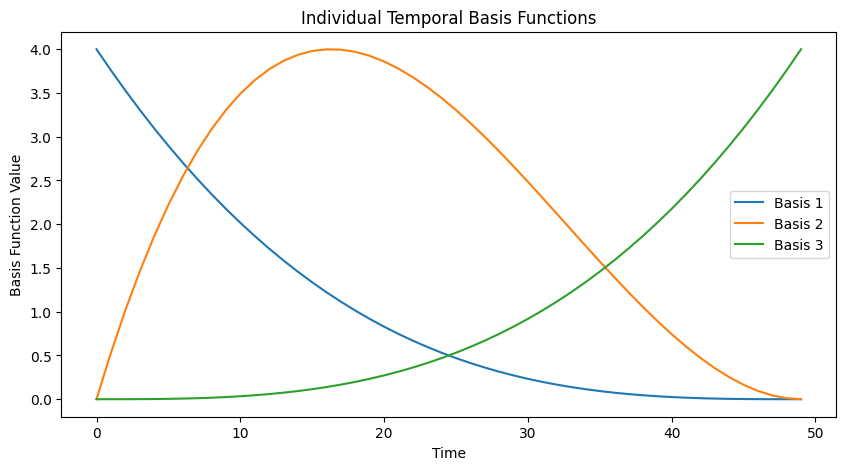

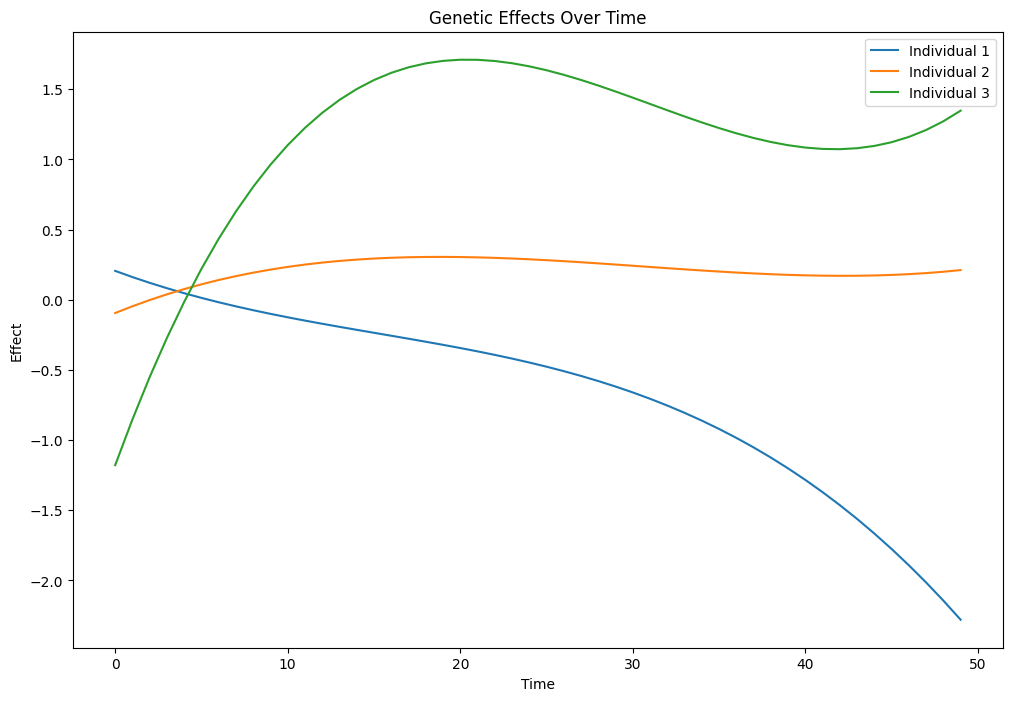

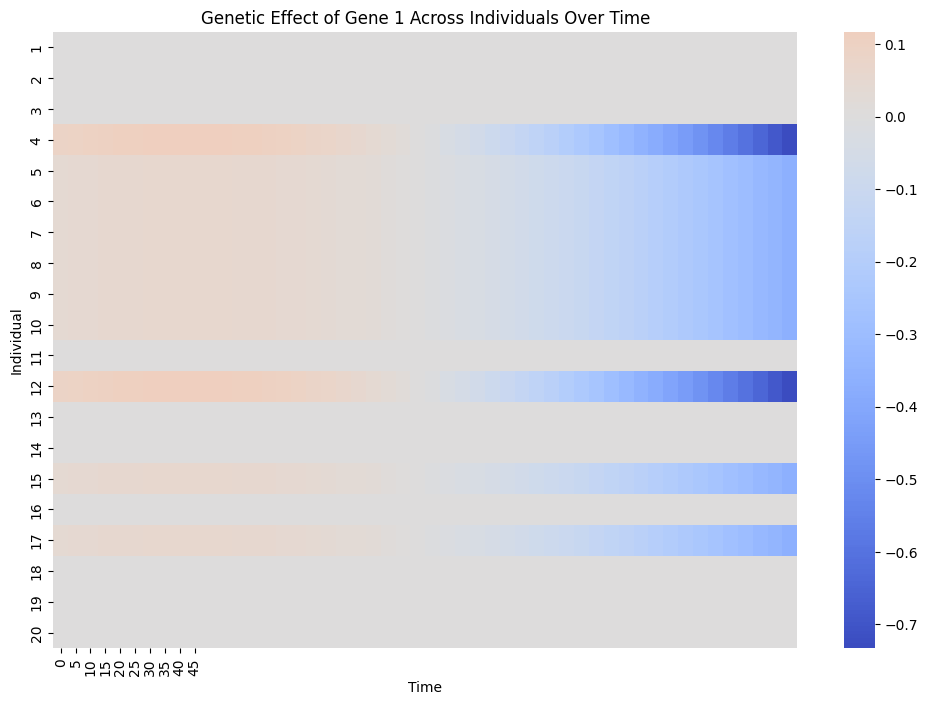

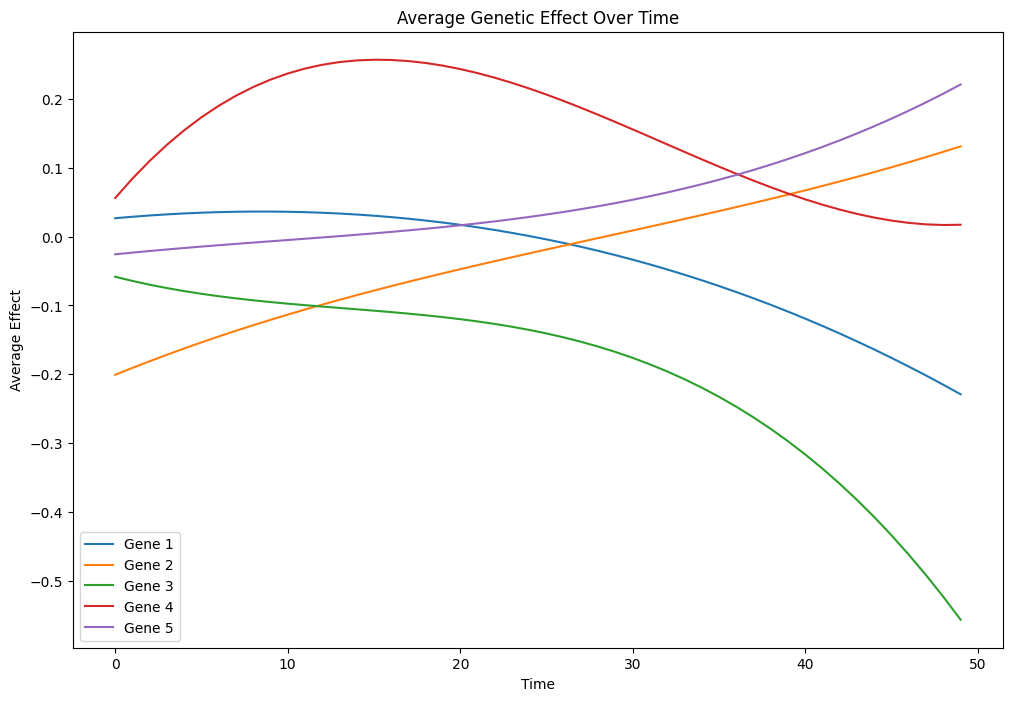

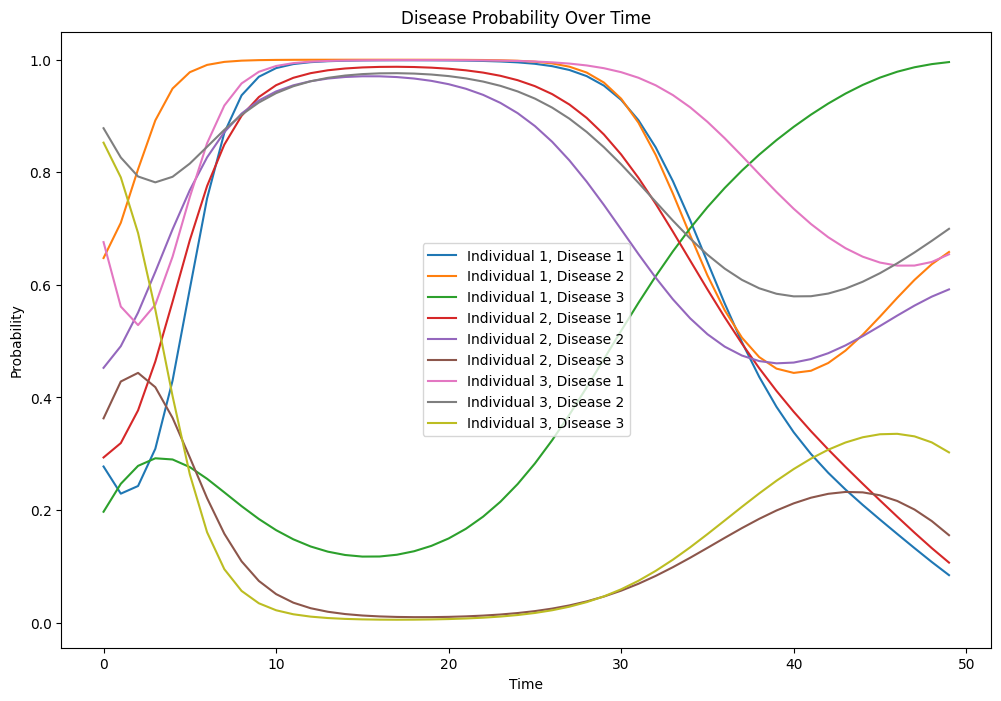

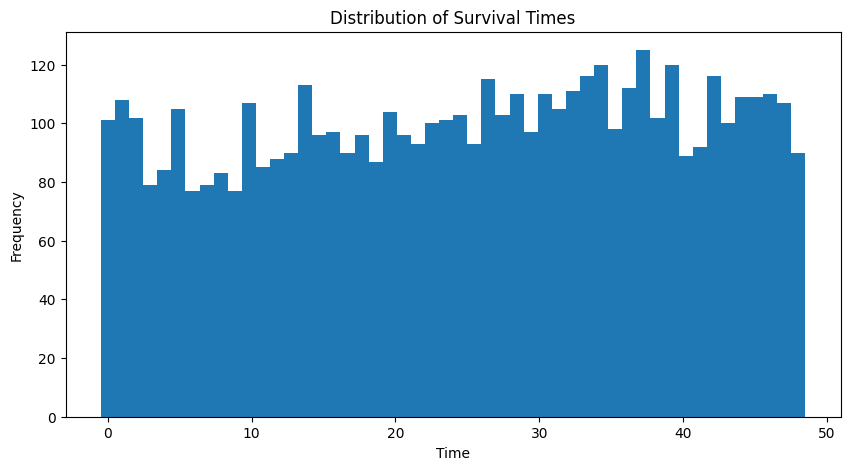

In [3]:

plot_basis_functions(model)
plot_genetic_effects_over_time(model)
plot_gene_heatmap(model, gene_index=0)
plot_average_gene_effects(model)
plot_disease_probabilities(model, pi_true)
plot_survival_times(S, T)


Ok now we want to fit the model to the data using  the inference of Chenyin.

In [7]:
model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)

# Generate data (or use your existing data)
theta_true = model.compute_theta()
pi_true = expit(theta_true)
Y, S = generate_survival_data(pi_true, N, D, T)


We are going to assume that U1(G) is solely a funciton of G and infludenced indepenently of C, so C will not be estimated.

In [4]:
# Known parameters
G_known = true_model.G
U2 = true_model.U2
U3 = true_model.U3

 A1 and A2 in previous code: 

A1 (N x K) represents the average individual loadings across all time points.
A2 (D x K) represents the average disease loadings across all time points.
These can be thought of as the "time-independent" or "average" loadings for individuals and diseases respectively.

For each individual n and factor k, there are R1 coefficients that determine how that individual's loading on that factor varies over time.
 Similarly, for each disease d and factor k, there are R2 coefficients that determine how that disease's loading on that factor varies over time.

We will call these U1G_init and W_init. 

In [5]:
# Initialize B and W
# Initialize U1G and W
U1G_init, w, W_init = svds(Y.mean(axis=2), k=K)
U1G_init = U1G_init @ np.diag(np.sqrt(w))
W_init = (np.diag(np.sqrt(w)) @ W_init).T


Now e'll project U1G_init onto the space spanned by the covariates (G) and the temporal basis (U2) first, and then solve for B. Here's the corrected initialization part:


In [6]:
# Project U1G_init onto the space spanned by the covariates and temporal basis
U1G_init = np.repeat(U1G_init[:, :, np.newaxis], T, axis=2)
U1G_init = tl.tenalg.mode_dot(U1G_init, np.linalg.pinv(U2.T @ U2) @ U2.T, mode=2)
U1G_init = tl.tenalg.mode_dot(U1G_init, G_known @ np.linalg.pinv(G_known.T @ G_known) @ G_known.T, mode=0)


Similarly, project W onto the space spanned by the temporal basis

In [7]:
print(U1G_init.shape)
print(W_init.shape)


(1000, 4, 3)
(5, 4)


In [8]:
W = tl.tenalg.mode_dot(np.repeat(W_init[:, :, np.newaxis],T, axis=2),
                       np.linalg.pinv(U3.T @ U3) @ U3.T, mode=2)

print(W.shape)

(5, 4, 3)


In [11]:
# Optimization parameters
stepsize = 0.1
alpha = 0.5
beta = 0.8
stepsize_U1G = stepsize_W = stepsize
niters = 1000
t_idx = len(Y.shape) - 1

def survival_likelihood(Y, S, theta):
    pi = expit(theta)
    log_likelihood = 0
    for n in range(N):
        for d in range(D):
            t = S[n, d]
            log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
            if Y[n, d, t] == 1:
                log_likelihood += np.log(pi[n, d, t] + 1e-10)
    return log_likelihood


1. Model structure: U1G = G @ B + C
Known components:
G (genetic data)
C (non-genetic effects)
Unknown component:
B (genetic effects)
4. Optimization focus:
Since G and C are known, the only part of U1G that we need to optimize is B. This is why we're updating B directly in each iteration.
Gradient computation:
When we compute the gradient for B, we're essentially asking, "How should we change B to improve our model's fit, given the fixed G and C?"
6. Updating process:
We update B based on its gradient.
Then we recompute U1G using the updated B and the fixed G and C.
This new U1G is used to compute the new theta and evaluate the model's performance.
This approach allows us to:
Maintain the correct structure of U1G throughout the optimization.
Focus our optimization efforts solely on the unknown genetic effects (B).
Incorporate our knowledge of the non-genetic effects (C) without trying to re-estimate them.
```
U1G = G @ B + C
θ = λ_k ⊗ φ = (U1G ⊗1 U2) ⊗ (W ⊗_2 U3)
We want to find ∂L/∂B, where L is our loss function.
Using the chain rule:
∂L/∂B = ∂L/∂θ ∂θ/∂U1G ∂U1G/∂B
1. ∂L/∂θ is our L_nabla
∂θ/∂U1G = U2 ⊗ φ
∂U1G/∂B = G^T
Putting this together:
∂L/∂B = G^T @ [(L_nabla ⊗3 U2^T) ⊙ φ]
Where ⊙ is the Hadamard (element-wise) product.
In code, this translates to:
```


In [ ]:
from scipy.special import expit
import numpy as np
import tensorly as tl
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from utils_binaryTensor_Sarah import (TensorModelWithGenetics, generate_survival_data,plot_genetic_effects_over_time, plot_gene_heatmap,
                                      plot_average_gene_effects, plot_basis_functions,
                                      plot_disease_probabilities, plot_survival_times)



In [ ]:
N, P, D, K, R1, R2, T = 1000, 20, 5, 4, 3, 3, 50

# Generate synthetic data
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
true_model.initialize_parameters()

theta_true = true_model.compute_theta()
pi_true = expit(theta_true)

G = true_model.G # the genetic covariates for each individual
U2 = true_model.U2
U3 = true_model.U3
W=true_model.W
U1G = true_model.compute_U1G()
# Compute lambda_k and phi
lambda_k = tl.tenalg.mode_dot(U1G, true_model.U2, 2)
phi = tl.tenalg.mode_dot(true_model.W, true_model.U3, 2)
# Compute theta
Y, S = generate_survival_data(pi_true, N, D, T)

# generate binary outcomes
error = np.random.logistic(scale = 1, loc = 0, size = (N, D, T))
Y_binary = ((theta_true + error)>0).astype('int')


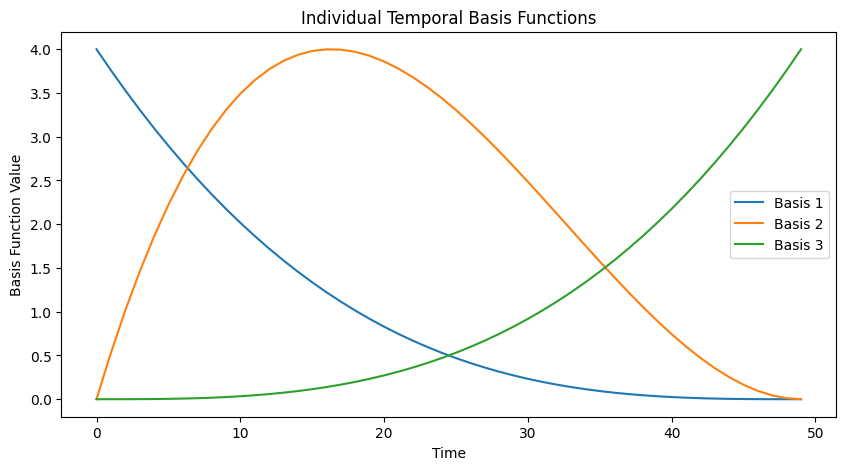

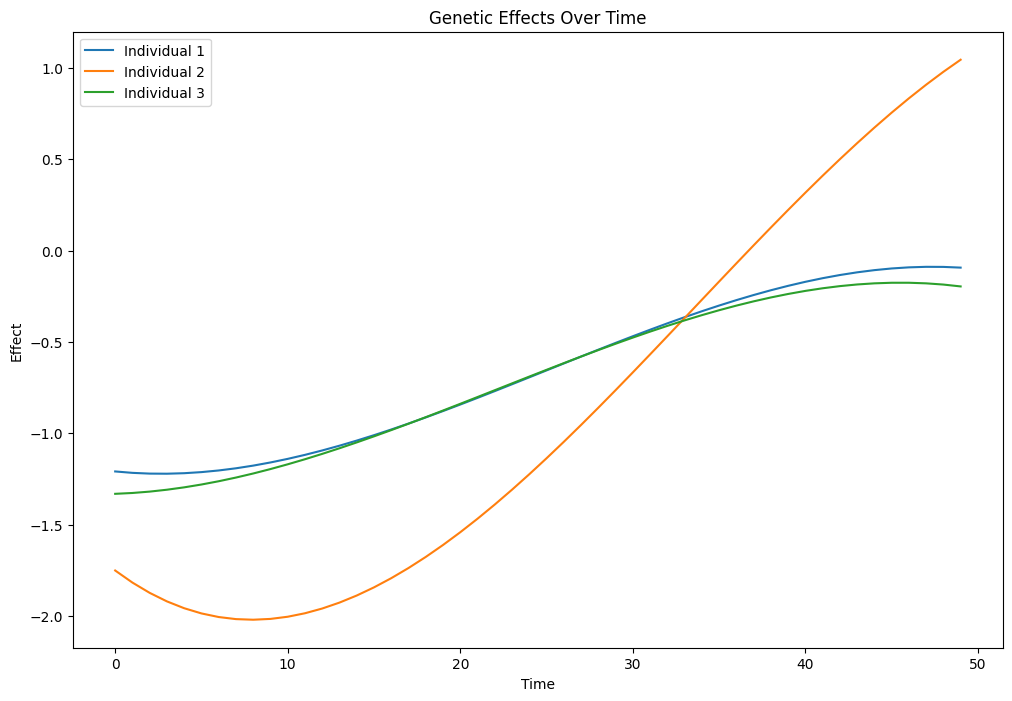

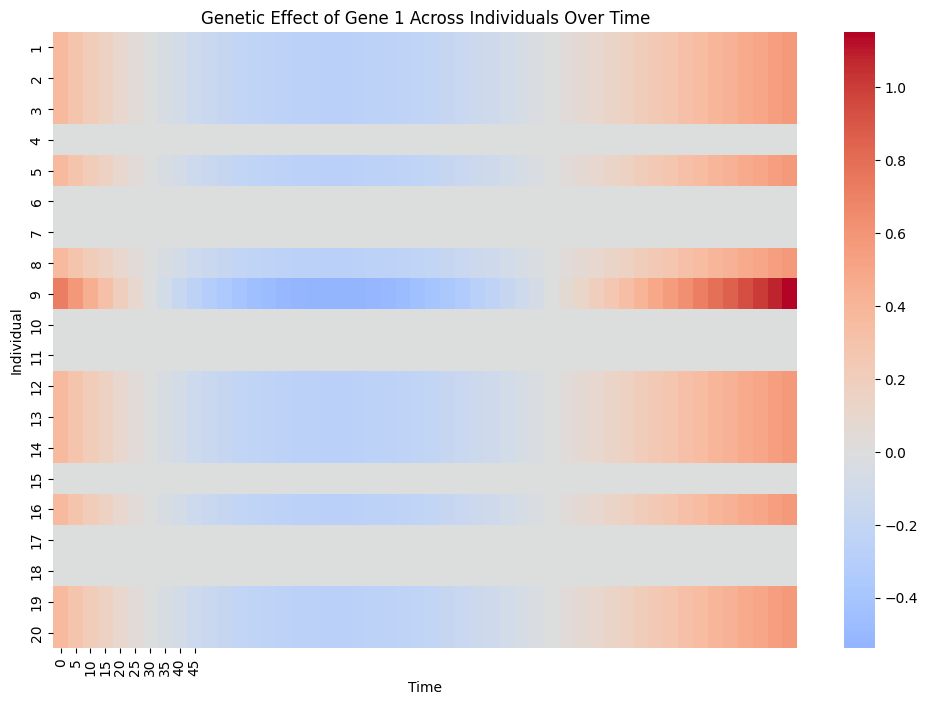

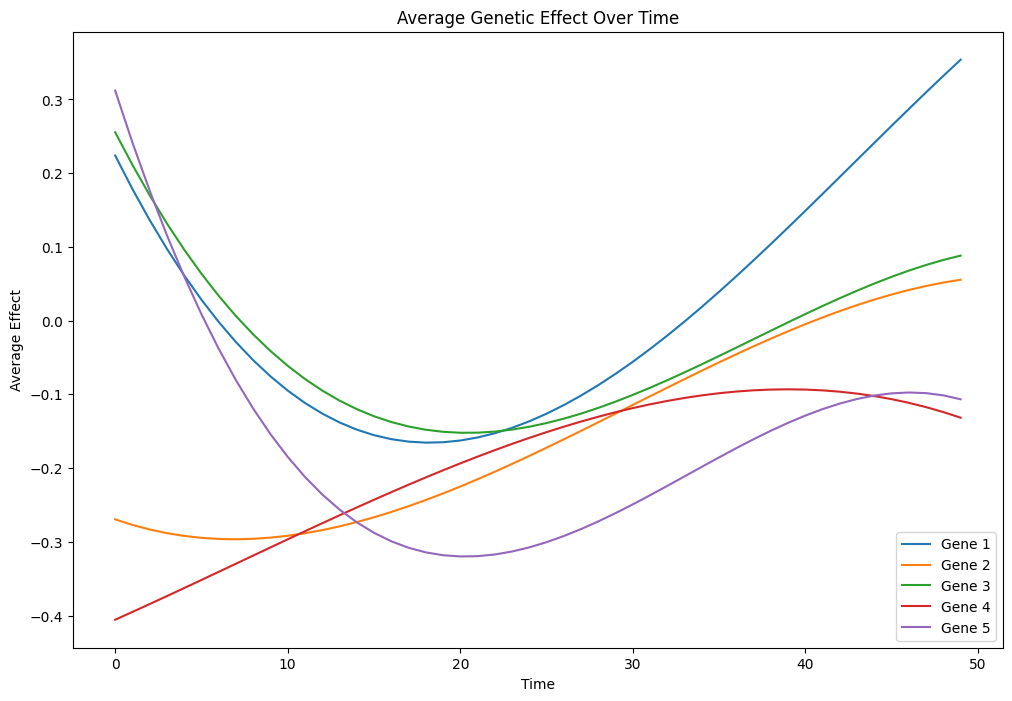

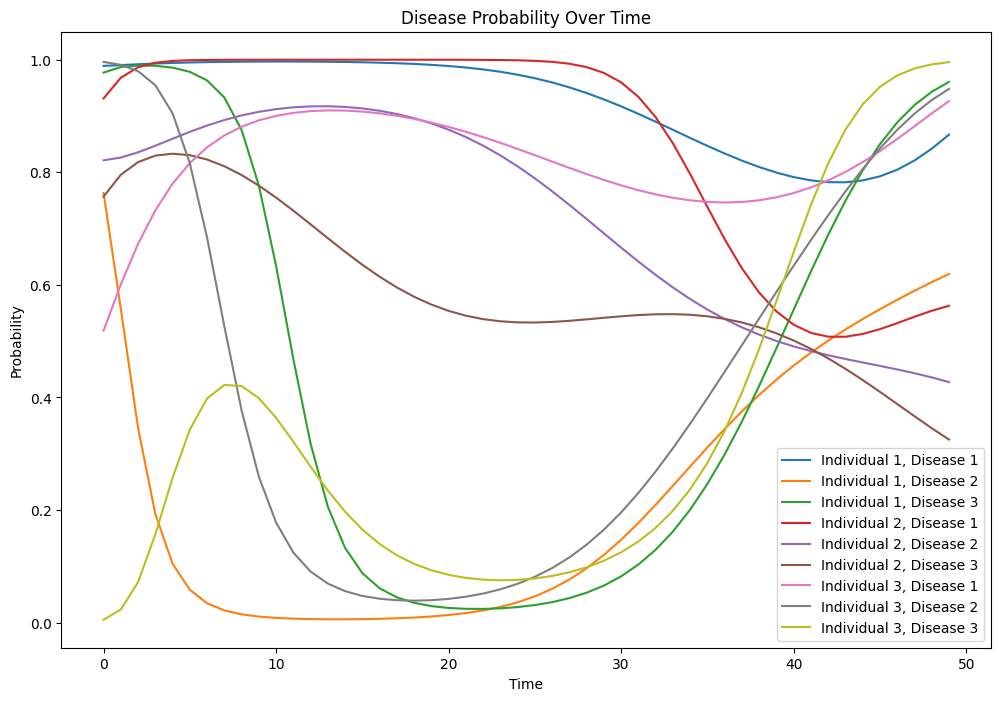

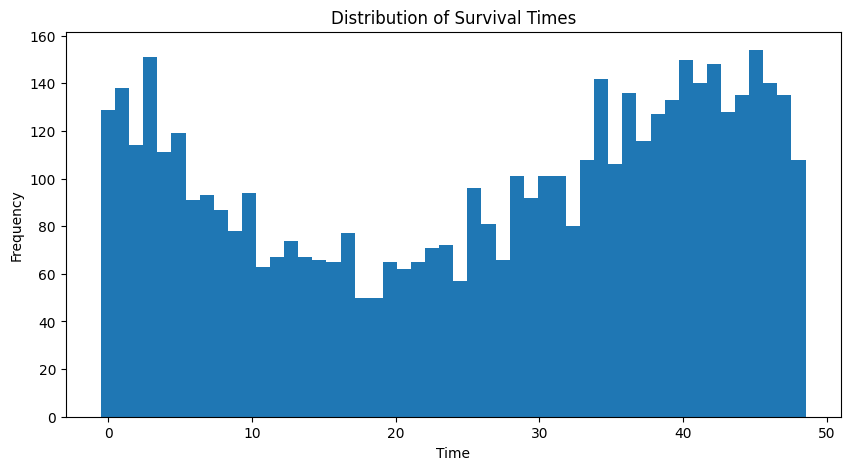

In [ ]:
model=true_model
plot_basis_functions(model)
plot_genetic_effects_over_time(model)
plot_gene_heatmap(model, gene_index=0)
plot_average_gene_effects(model)
plot_disease_probabilities(model, pi_true)
plot_survival_times(S, T)


Ok now we want to fit the model to the data using  the inference of Chenyin.

In [ ]:
model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)

# Generate data (or use your existing data)
theta_true = model.compute_theta()
pi_true = expit(theta_true)
Y, S = generate_survival_data(pi_true, N, D, T)


In [ ]:
# Known parameters
G_known = true_model.G
C_known = true_model.C
U2 = true_model.U2
U3 = true_model.U3

 A1 and A2 in previous code: 

A1 (N x K) represents the average individual loadings across all time points.
A2 (D x K) represents the average disease loadings across all time points.
These can be thought of as the "time-independent" or "average" loadings for individuals and diseases respectively.

For each individual n and factor k, there are R1 coefficients that determine how that individual's loading on that factor varies over time.
 Similarly, for each disease d and factor k, there are R2 coefficients that determine how that disease's loading on that factor varies over time.

We will call these U1G_init and W_init. 

In [31]:
# Initialize B and W
# Initialize U1G and W
U1G_init, w, W_init = svds(Y.mean(axis=2), k=K)
U1G_init = U1G_init @ np.diag(np.sqrt(w))
W_init = (np.diag(np.sqrt(w)) @ W_init).T


Now e'll project U1G_init onto the space spanned by the covariates (G) and the temporal basis (U2) first, and then solve for B. Here's the corrected initialization part:


In [32]:
# Project U1G_init onto the space spanned by the covariates and temporal basis
U1G_init = np.repeat(U1G_init[:, :, np.newaxis], T, axis=2)
U1G_init = tl.tenalg.mode_dot(U1G_init, np.linalg.pinv(U2.T @ U2) @ U2.T, mode=2)
U1G = tl.tenalg.mode_dot(U1G_init, G_known @ np.linalg.pinv(G_known.T @ G_known) @ G_known.T, mode=0)


In [33]:
U1G_init.shape

(1000, 4, 3)

Similarly, project W onto the space spanned by the temporal basis

In [34]:
W = tl.tenalg.mode_dot(np.repeat(W_init[:, :, np.newaxis],T, axis=2),
                       np.linalg.pinv(U3.T @ U3) @ U3.T, mode=2)

# 

In [35]:
# Optimization parameters
stepsize = 0.1
alpha = 0.5
beta = 0.8
stepsize_B = stepsize_W = stepsize
niters = 1000

In [36]:
def survival_likelihood(Y, S, theta, epsilon=1e-10):
    pi = np.clip(expit(theta), epsilon, 1 - epsilon)
    log_likelihood = 0
    for n in range(N):
        for d in range(D):
            t = S[n, d]
            log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + epsilon))
            if Y[n, d, t] == 1:
                log_likelihood += np.log(pi[n, d, t] + epsilon)
    return log_likelihood

In [37]:
for it in range(niters):
    # Compute time-varying versions
    lambda_k = tl.tenalg.mode_dot(U1G, U2, 2)
    phi = tl.tenalg.mode_dot(W, U3, 2)
    
    theta_pre = np.einsum("nkt,dkt->ndt", lambda_k, phi)
    
    if np.any(np.isnan(theta_pre)) or np.any(np.isinf(theta_pre)):
        print(f"NaN or inf detected in theta_pre at iteration {it}")
        break

    # Compute L_nabla (gradient of log-likelihood)
    pi = expit(theta_pre)
    L_nabla = np.zeros_like(theta_pre)
    for n in range(N):
        for d in range(D):
            t = S[n, d]
            L_nabla[n, d, :t] = -pi[n, d, :t]
            if Y[n, d, t] == 1:
                L_nabla[n, d, t] += 1

    # Unfold along the first and second modes at each time
    L_nabla_mode0 = np.stack([tl.unfold(L_nabla[:, :, idx], mode=0) for 
                              idx in range(L_nabla.shape[t_idx])], axis=t_idx)
    L_nabla_mode1 = np.stack([tl.unfold(L_nabla[:, :, idx], mode=1) for 
                              idx in range(L_nabla.shape[t_idx])], axis=t_idx)

    # Compute loss
    loss_pre = survival_likelihood(Y, S, theta_pre)
    
    # Compute gradients
    grad_W = tl.tenalg.mode_dot(np.einsum('ijt,jkt->ikt', L_nabla_mode1, lambda_k),
                                U3.T, 2)
    
    W_tilde = W - stepsize_W * grad_W
    
    # Compute new loss for W
    phi_tilde = tl.tenalg.mode_dot(W_tilde, U3, 2)
    loss_after_W = survival_likelihood(Y, S, np.einsum("nkt,dkt->ndt", lambda_k, phi_tilde))

    # Backtracking line search for W
    while loss_after_W < loss_pre - alpha * stepsize_W * np.linalg.norm(grad_W)**2:
        stepsize_W *= beta
        W_tilde = W - stepsize_W * grad_W
        phi_tilde = tl.tenalg.mode_dot(W_tilde, U3, 2)
        loss_after_W = survival_likelihood(Y, S, np.einsum("nkt,dkt->ndt", lambda_k, phi_tilde))
    
    W = W_tilde
    phi = tl.tenalg.mode_dot(W, U3, 2)

    # Gradient for U1G
    grad_U1G = tl.tenalg.mode_dot(np.einsum('jit,ikt->jkt', L_nabla_mode0, phi),
                                  U2.T, 2)

      # Add checks after computing gradients
    if np.any(np.isnan(grad_W)) or np.any(np.isinf(grad_W)) or \
       np.any(np.isnan(grad_U1G)) or np.any(np.isinf(grad_U1G)):
        print(f"NaN or inf detected in gradients at iteration {it}")
        break

    U1G_tilde = U1G - stepsize_U1G * grad_U1G
    U1G_tilde = tl.tenalg.mode_dot(U1G_tilde, G_known @ np.linalg.pinv(G_known.T @ G_known) @ G_known.T, mode=0)

    # Compute new loss for U1G
    lambda_k_tilde = tl.tenalg.mode_dot(U1G_tilde, U2, 2)
    loss_after_U1G = survival_likelihood(Y, S, np.einsum("nkt,dkt->ndt", lambda_k_tilde, phi))

    # Backtracking line search for U1G
    while loss_after_U1G < loss_pre - alpha * stepsize_U1G * np.linalg.norm(grad_U1G)**2:
        stepsize_U1G *= beta
        U1G_tilde = U1G - stepsize_U1G * grad_U1G
        U1G_tilde = tl.tenalg.mode_dot(U1G_tilde, G_known @ np.linalg.pinv(G_known.T @ G_known) @ G_known.T, mode=0)
        lambda_k_tilde = tl.tenalg.mode_dot(U1G_tilde, U2, 2)
        loss_after_U1G = survival_likelihood(Y, S, np.einsum("nkt,dkt->ndt", lambda_k_tilde, phi))
    
    if np.isnan(loss_after) or np.isinf(loss_after):
        print(f"NaN or inf detected in loss at iteration {it}")
        break

    U1G = U1G_tilde
    lambda_k = tl.tenalg.mode_dot(U1G, U2, 2)

    theta_after = np.einsum("nkt,dkt->ndt", lambda_k, phi)
    loss_after = survival_likelihood(Y, S, theta_after)
    
    # Check for convergence
    tol_temp = np.abs(loss_pre - loss_after) / np.abs(loss_pre)
    
    if it % 100 == 0:
        print(f'{it}th iteration with loss: {np.round(loss_after,3)}')
    
    if tol_temp < 1e-5 and (stepsize_W < 1e-6 or stepsize_U1G < 1e-6):
        print('Stop: not enough improvement')
        break

In [15]:
# Time-varying individual loadings
lambda_k = tl.tenalg.mode_dot(U1G, U2, 2)  # Shape: (N, K, T)

# Time-varying disease weights
phi = tl.tenalg.mode_dot(W, U3, 2)  # Shape: (D, K, T)

# Full predicted tensor
theta_pred = np.einsum('nkt,dkt->ndt', lambda_k, phi)

# Predicted probabilities
pi_pred = expit(theta_pred)

In [ ]:

pi_true = expit(theta_true)
pi_fit = expit(theta_fit)
# Plot true vs estimated pi for a few randomly selected individuals and diseases
num_samples = 5
sample_individuals = np.random.choice(N, num_samples, replace=False)
sample_diseases = np.random.choice(D, num_samples, replace=False)

plt.figure(figsize=(15, 15))
for i, (n, d) in enumerate(zip(sample_individuals, sample_diseases)):
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(pi_true[n, d, :], label='True')
    plt.plot(pi_fit[n, d, :], label='Estimated')
    plt.title(f'Individual {n}, Disease {d}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.scatter(pi_true[n, d, :], pi_fit[n, d, :])
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.xlabel('True Probability')
    plt.ylabel('Estimated Probability')
    plt.title(f'True vs Estimated (Ind {n}, Disease {d})')

plt.tight_layout()
plt.show()